In [34]:
import pandas as pd

import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
import random
import numpy as np
import scipy
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import pickle
from collections import Counter

import matplotlib.pyplot as plt

import sys

scripts_dir = '../scripts/'
sys.path.append(scripts_dir)
import IDseq_pathogen_functions2 
import IDSeq_plotting_functions_v2
import IDSeq_utility_functions

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [35]:
def sqrt_value(matrix):
    matrix['perc_NR2'] = np.sqrt(matrix['perc_NR2'])
    matrix['perc_NT2'] = np.sqrt(matrix['perc_NT2'])
    #return matrix
    
def round_rpm(matrix):
    #X['log(NR_rpm)'] = np.round(X['log(NR_rpm)'])
    #X['perc_NR2'] = np.round(X['perc_NR2']*10)
    X['perc_NTr'] = np.round(X['perc_NTr']*100)
    X['perc_NRr'] = np.round(X['perc_NRr']*100)

In [36]:
output_directory = '080618_M4'

# Parse out the relevant features from Figure S1 - generated in main analysis above.
X = pd.read_csv("./output/073018/microbe_data.csv", index_col = 0)

# look only at RNA-seq files (since this project contained both, this is an extra filtration step)
X = X[X['RNA'] == True]

#sqrt_value(X)
round_rpm(X)

In [37]:
parameters = IDSeq_utility_functions.parse_params("./reference/config.txt")

In [38]:
# Separate out by group membership for training and analysis of True Positive / True Negative
X_label_positive = X[X[parameters['label']] == parameters['positive_class']]
X_unk = pd.concat([X[X[parameters['label']] == i] for i in parameters['unknown_class']])

X_label_negative = X[X[parameters['label']] == parameters['negative_class']]
X_labelled = pd.concat([X_label_positive, X_label_negative], axis=0)

X_train = X_labelled[X_labelled['sampleID'].isin(parameters['training_set'])] 
X_test = X_labelled[~X_labelled['sampleID'].isin(parameters['training_set'])] 

# generate the outcome vectors based on whether microbe was identified by standard microbiology
Y_label_positive = X_label_positive['positive'].tolist()
Y_unk = X_unk['positive'].tolist()
Y_label_negative = X_label_negative['positive'].tolist()
Y_labelled = X_labelled['positive'].tolist()

y_train = list(X_train['positive'])

In [39]:
print("sklearn version:")
print(sklearn.__version__)

# 1 - training_variables = ['log(genus_NT_rpm)','reference_pathogen','perc_NTr'] NTr is rounded // patho AUC = 0.882 // LRTI AUC = 0.889 and 0.945 
# 2 - ['log(NT_rpm)','reference_pathogen','perc_NTr'] NTr is rounded // pathog AUC = 0.881 // LRTI AUC = 0.889 and 0.938
# 3 - ['log(NR_rpm)','reference_pathogen','perc_NRr'] NRr is rounded // patho AUC = 0.88 // LRTI AUC = 0.956 and 0.969
# 4 - ['log(genus_NR_rpm)','reference_pathogen','perc_NRr'] NRr is rounded  // patho AUC = 0.88 // LRTI AUC = 0.90 and 0.969
# 5 - ['log(NR_rpm)', 'log(NT_rpm)','reference_pathogen','perc_NTr']  NTr is rounded // patho AUC = 0.87  LRTI AUC = 0.87 AND 0.938
# 6 - ['log(NR_rpm)','reference_pathogen','perc_NRr'] NRr is rounded, but NO threshold on # of pathogens allowed (previously 15)... NOT GOOD
# 7 - ['log(NR_rpm)','reference_pathogen','perc_NTr'] NTr is rounded 0.883, 0.96, 0.91
# 8 - ['log(NT_rpm)','reference_pathogen','rank']
# 9 - ['log(NR_rpm)','reference_pathogen','perc_NR2']
# 10 -  ['log(NT_rpm)','reference_pathogen','perc_NTr','perc_NRr'] 
# 11 -  ['log(genus_NT_rpm)','reference_pathogen','perc_NTr','NT_zscore'] 

# NT across the board and NR across the board both appear similar in performance metrics. But NT has much higher separation of top scoring microbe from the next microbe.

# M1 0806 ['log(genus_NT_rpm)','reference_pathogen','perc_genus_NTr'], output = 080618_M1
# M2 0806 ['log(NT_rpm)','reference_pathogen','perc_NTr'], output = 080618_M2
# M3 0806 ['log(NR_rpm)','reference_pathogen','perc_NRr'], output = 080618_M3
# M4 0806 ['log(genus_NR_rpm)','reference_pathogen','perc_genus_NRr'], output = 080618_M4


training_variables = ['log(genus_NR_rpm)','reference_pathogen','perc_genus_NRr']  #parameters['model_parameters'] # #,]  

many_rounds_train_auc = []
many_rounds_test_auc = []
tprs_iterative = []
aucs_iterative = []
mean_fpr_iterative = np.linspace(0, 1, 100)

# set up training data
X_train_pos = X_train[X_train['positive'] == True]
X_train_neg = X_train[X_train['positive'] == False]

c = ['blue','red']

sklearn version:
0.18.1


In [40]:
# LOPO-CV schematic is as follows:
# IN EACH ITERATION...
#  1. Remove all microbes from one sampleID
#  2. Train on microbes from all other sampleIDs
#  3. Predict for all microbes in the held-out sampleID
# This results in the predicted [pathogen v. commensal] probability for each microbe 
# in the training set

#
# RUN LOPO-CV ON ALL GROUP 1 AND GROUP 4 PATIENTS
#

# full training data
Y_train = X_train[['positive']]

sampleIDs_to_remove = list(set(X_train['sampleID']))  # names of each sampleID in the training set
predictions = []
truths = []
training_auc = []
sampleID_max_scores = {}
sampleID_groups = {}

for i in sampleIDs_to_remove:  # loop through all sampleIDs
    
    # training set is all g1g4_train microbes that are not from sampleID = i
    X_train_sub = X_train[X_train['sampleID'] != i]
    X_train_sub2 = X_train_sub[training_variables]   
    y_train_sub = X_train_sub[X_train_sub['sampleID'] != i]['positive']

    # test set is all g1g4_train microbes that are from sampleID = i
    X_test_sub = X_train[X_train['sampleID'] == i] 
    X_test_sub2 = X_test_sub[training_variables]   
    y_test_sub = X_test_sub['positive']

    lr = linear_model.LogisticRegression(C=1000000) # large C, effectively no regularization
    lr.fit(X_train_sub2, y_train_sub)                        # fit the logistic regression model
    p_test = lr.predict_proba(X_test_sub2)[:,1]          # predict on the left-out sub test set
    p_train = lr.predict_proba(X_train_sub2)[:,1]        # predict on the training set 
    
    # METRICS for evaluating model performance
    predictions = predictions + list(p_test) # append subset predictions to list of all predictions
    truths = truths + list(y_test_sub)    # append truth values to list of all true classifications
    training_auc.append(metrics.roc_auc_score([int(j) for j in y_train_sub], p_train))  # calculate AUC for training subset
        
    # track the maximum pathogen v. commensal score per sampleID
    sampleID_max_scores[i] = max(list(p_test))  
    sampleID_groups[i] = list(X_test_sub[parameters['label']])[0]   # track the LRTI group
        
    count = 0
    
    # append the pathogen v. commensal LRM "score" value to each row of the X_g1g4_train matrix ...
    # ... for downstream plots 
    for j in X_train[X_train['sampleID'] == i].index:  
        X_train.loc[j,'score'] = p_test[count]
        count += 1
        
#print("Mean AUC for LOPO-CV training: " + str(np.mean(training_auc)))  
print("\nTotal AUC for LOPO-CV predictions: " + str(metrics.roc_auc_score([int(i) for i in truths], predictions)))
IDseq_pathogen_functions2.get_CI([int(i) for i in truths], predictions, 1000);

# Youden's index for pathogen v. commensal model 
# We are not using this in the analysis for consistency in threshold btwn pathogen v. 
# commensal and LRTI v. no-LRTI models
# youdens_patho_commensal_model = IDseq_pathogen_functions2.Find_Optimal_Cutoff([int(i) for i in truths], predictions)
# print("Youden's training pathogen v. commensal: " + str(youdens_patho_commensal_model))


Total AUC for LOPO-CV predictions: 0.8883053221288516
Original ROC area: 0.888, [0.740 - 0.981]


AUC for distinguishing LRTI+C+M v. no-LRTI sampleIDs (train)= 0.9222222222222223


No handles with labels found to put in legend.


Original ROC area: 0.922, [0.800 - 1.0]

At probability threshold = 0.2
TP, FP, TN, FN
(8, 1, 8, 2)


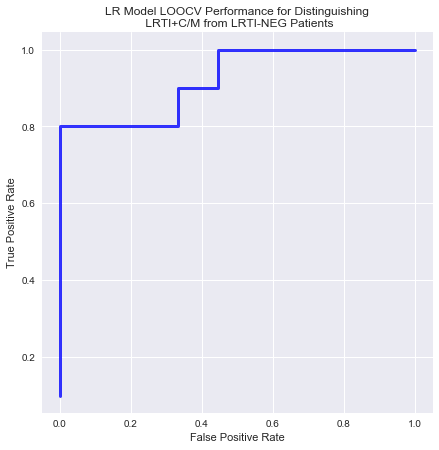

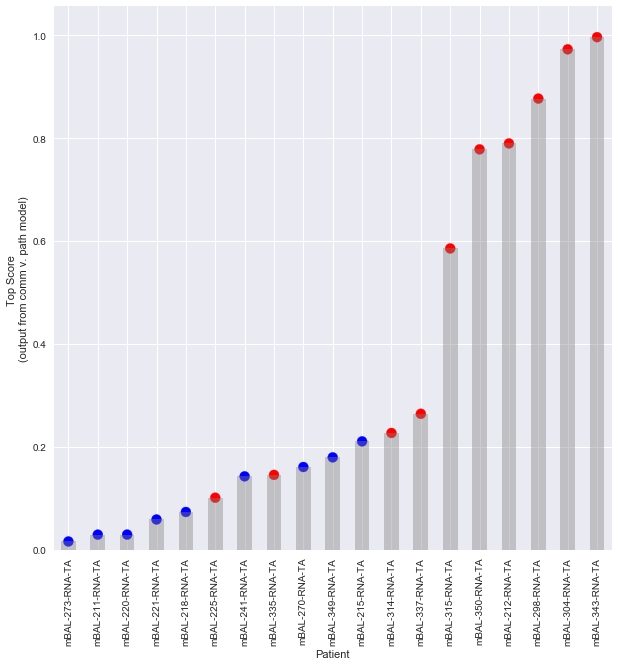

P-value for top microbe score in LRTI+C/M versus LRTI-NEG: 0.0019177234280989466


In [41]:
# USE THE PATIENT-SPECIFIC MAX SCORE VALUE TO CREATE A CLASSIFIER FOR G1 V. G4 PATIENTS...
# actually, we only have 1 feature so we will just evaluate the AUC.

PROBABILITY_THRESHOLD=.2

scores = []
group = []
sampleID_names = []
for i in sampleID_max_scores.keys():
    scores.append(sampleID_max_scores[i])
    group.append(sampleID_groups[i])
    sampleID_names.append(i)
    
# Generate AUC curve for predicting Group 1 v. Group 4 from the top microbe score
#youdens_sampleID_microbe_model = IDseq_pathogen_functions2.Find_Optimal_Cutoff(group, scores)
#print("Youden's training sampleID microbe: " + str(youdens_sampleID_microbe_model))
fpr, tpr, thresholds = metrics.roc_curve(group, scores, pos_label=parameters['positive_class'])  
print("AUC for distinguishing LRTI+C+M v. no-LRTI sampleIDs (train)= " + 
      str(metrics.roc_auc_score([int(i==parameters['positive_class']) for i in group], scores)))
IDseq_pathogen_functions2.get_CI([int(i==parameters['positive_class']) for i in group], scores, 1000)

print("\nAt probability threshold = " + str(PROBABILITY_THRESHOLD))
print("TP, FP, TN, FN")
print(IDseq_pathogen_functions2.perf_measure([i > PROBABILITY_THRESHOLD for i in scores], 
                                      [int(i==parameters['positive_class']) for i in group]))


# PLOT: Figure S3
# AUC curve for LRTI+C+M v. no-LRTI using the max. pathogen v. commensal probability per sampleID
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='b', lw=3, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Model LOOCV Performance for Distinguishing\n LRTI+C/M from LRTI-NEG Patients')
plt.legend(loc="lower right")
plt.savefig('./output/' + output_directory + '/FigureS2.pdf')
plt.show()

# PLOT: max predicted probability score by sampleID - for visualization and 
# double-checking feasability of AUC
plt.ylabel("Top Score \n(output from comm v. path model)")
plt.xlabel("Patient")
c=['b','r']
df = pd.DataFrame.from_dict(sampleID_max_scores, orient='index')
df.index = [i.split('.')[0] for i in df.index]
df['color'] = [int(i == parameters['positive_class']) for i in group]
df.sort_values(by=0,inplace=True)
df[0].plot(kind='bar',color='grey',alpha=.4, figsize=(10,10))
plt.scatter([i for i in range(len(df[0]))],df[0],color=[c[i] for i in df['color']],s=100)
plt.savefig('./output/' + output_directory + '/FigureX1.pdf')
plt.show()
#print(df[0])  # print out the sampleID ID and max microbe score (same as plot)


# evaluate the p-value of scores from group 1 and group 4
group1_scores = []
group4_scores = []
for i in range(len(group)):
    if int(group[i] == parameters['positive_class']):
        group1_scores.append(scores[i])
    else:
        group4_scores.append(scores[i])

print("P-value for top microbe score in LRTI+C/M versus LRTI-NEG: " + 
      str(scipy.stats.ranksums(group1_scores,group4_scores).pvalue))

# Create the data for per-sampleID heatmap view showing all microbes that passed 
# the threshold for all sampleIDs (in groups 1 and group 4)
creating_matrix_from_train = X_train[X_train['score'] > PROBABILITY_THRESHOLD]
sampleID_by_microbe_predicted_train = creating_matrix_from_train[['name',
                                                                  'sampleID',
                                                                  'genus_name']]
sampleID_by_microbe_predicted_train.index = [i for i in range(len(
    sampleID_by_microbe_predicted_train.index))]


LRM Model Coefficients for final pathogen v. commensal trained model:
['log(genus_NR_rpm)', 'reference_pathogen', 'perc_genus_NRr']
[[8.44162024e-03 3.92643802e+00 1.48312432e+01]]

 # of Pathogens v. Commensals in Training and Test sets, respectively:
Counter({False: 238, True: 12})
Counter({False: 304, True: 23})
Test Performance for pathogen detection
Original ROC area: 0.924, [0.893 - 0.953]
[0.8927345537757436, 0.9526455026455026]


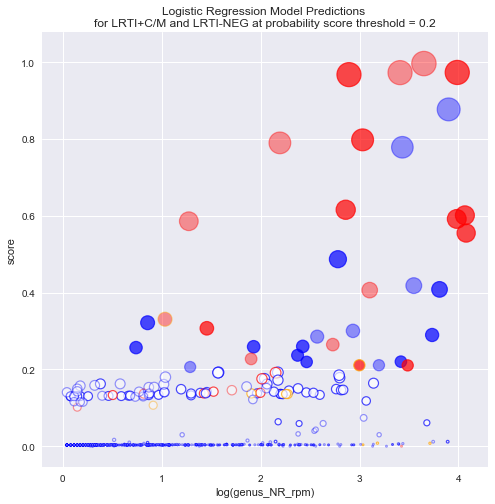

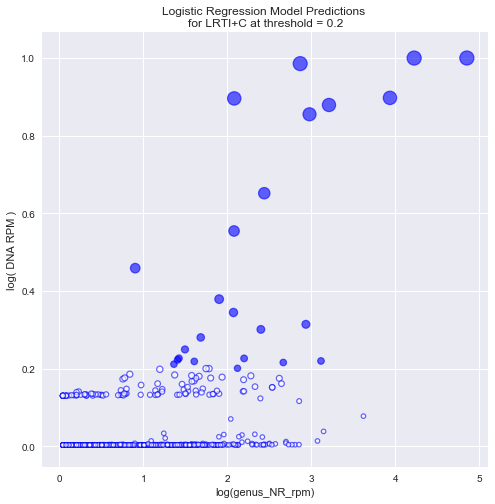

In [42]:
annotate_plots = False


# PLOT THE WEIGHTED PROJECTION OF EACH GROUP'S MICROBES 
# (WEIGHTED by THE PROBABILITY OUTPUT BY LINEAR MODEL)

# create fresh linear model; large C to run non-regularized regression
lr = linear_model.LogisticRegression(C=1000000)

# Train on all Group 1 and Group 4 sampleIDs
lr = lr.fit(X_train[training_variables],Y_train)

print("LRM Model Coefficients for final pathogen v. commensal trained model:")
print(training_variables)
print(lr.coef_)

# save the combined model to a pickle file 
pickle.dump(lr, open('./output/' + output_directory + '/mBAL_g1g4combo_logRegModel', 'wb'))  

#
# TRAIN ON ALL TEST SAMPLES FOR BOTH PATHOGEN V. COMMENSAL MODEL AND PATIENT MICROBE MODEL
#

c = ['blue','red'] # for G1 and G4 projection plot 
                   # (where some microbes were identified by clinical microbiology)
                   
# establish the test set
Y_test = list(X_test['positive'])
Y_train = list(X_train['positive'])

print("\n # of Pathogens v. Commensals in Training and Test sets, respectively:")
print(Counter(Y_train))
print(Counter(Y_test))

# Plot predicted probabilities for group 1 TEST SET sampleIDs' microbes
predicted = lr.predict_proba(X_test[training_variables])
X_test['score'] = predicted[:,1]  # append the predicted probabilities to the data matrix

print("Test Performance for pathogen detection")
print(IDseq_pathogen_functions2.get_CI(list(X_test['positive']), list(X_test['score']), 1000))


# PLOT: RNA v. DNA plot with microbes shown with probabilities.
plt.figure(figsize=[8,8])

# visualize the test set in RNA rM by DNA rM space;
plt.scatter(X_test[parameters['graph_axis']],
            X_test['score'],
            edgecolor=[c[int(X_test.loc[i]['positive'])] 
                       if X_test[X_test['sampleID'] == 
                                      X_test.loc[i]['sampleID']]['positive'].sum() < 2 
                       or c[int(X_test.loc[i]['positive'])] == 'blue' 
                       or X_test.loc[i]['score'] == max(
                           X_test[(X_test.sampleID == X_test.loc[i]['sampleID']) 
                                       & (X_test.positive == True)]['score']) 
                       else 'orange' for i in X_test.index],
            s=[max(i*600,3) for i in X_test['score']],
            facecolor=[c[int(Y_test[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(Y_test)) ],
            alpha=.7, linewidth=1.2) 

# add the scatterplot of predicted TRAINING microbes in RNA rM by DNA rM space;
plt.scatter(X_train[parameters['graph_axis']],
            X_train['score'],
            edgecolor=[c[int(X_train.loc[i]['positive'])] 
                       if X_train[X_train['sampleID'] == 
                                  X_train.loc[i]['sampleID']]['positive'].sum() < 2 
                       or c[int(X_train.loc[i]['positive'])] == 'blue' 
                       or X_train.loc[i]['score'] == max(
                           X_train[(X_train.sampleID == X_train.loc[i]['sampleID'])
                                   & (X_train.positive == True)]['score']) 
                       else 'orange' for i in X_train.index],
            s=[max(i*600,3) for i in X_train['score']],
            facecolor=[c[int(X_train.iloc[i]['positive'])] if X_train.iloc[i]['score'] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(X_train['positive'])) ],
            alpha=.4, linewidth=1.2) 

plt.title(
    "Logistic Regression Model Predictions \nfor LRTI+C/M and LRTI-NEG at probability score threshold = " + 
    str(PROBABILITY_THRESHOLD))
plt.xlabel(parameters['graph_axis'])
plt.ylabel("score")
plt.savefig('./output/' + output_directory + '/Figure2D.pdf')

plt.show()


print("\n\n")

#
# Predictions for Group 2 (LRTI+C) and Group 3 (unk-LRTI) sampleIDs
#

# LRTI+C PREDICTIONS

annotate_plots = False 
c = ['blue','blue']

# Plot predicted probabilities for group 2 sampleIDs' microbes
predicted = lr.predict_proba(X_unk[training_variables])
# append the group 2 pathogen v. commensal model to the original data matrix
X_unk['score'] = predicted[:,1]

plt.figure(figsize=[8,8])
plt.scatter(X_unk[parameters['graph_axis']],X_unk['score'],
            edgecolor=[c[int(i)] for i in Y_unk],
            s=[max(i*200,20) for i in predicted[:,1]],
            facecolor=[c[int(Y_unk[i])] if predicted[:,1][i] > 
                       PROBABILITY_THRESHOLD else 'white' for i in range(len(Y_unk)) ],
            alpha=.6, linewidth=1.2)  

plt.title("Logistic Regression Model Predictions \nfor LRTI+C at threshold = " + 
          str(PROBABILITY_THRESHOLD))
plt.xlabel(parameters['graph_axis'])
plt.ylabel('log( DNA RPM )')
plt.savefig('./output/' + output_directory + '/FigureS3B.pdf')



TRAINING RESULTS

TEST RESULTS

GROUP 2 RESULTS


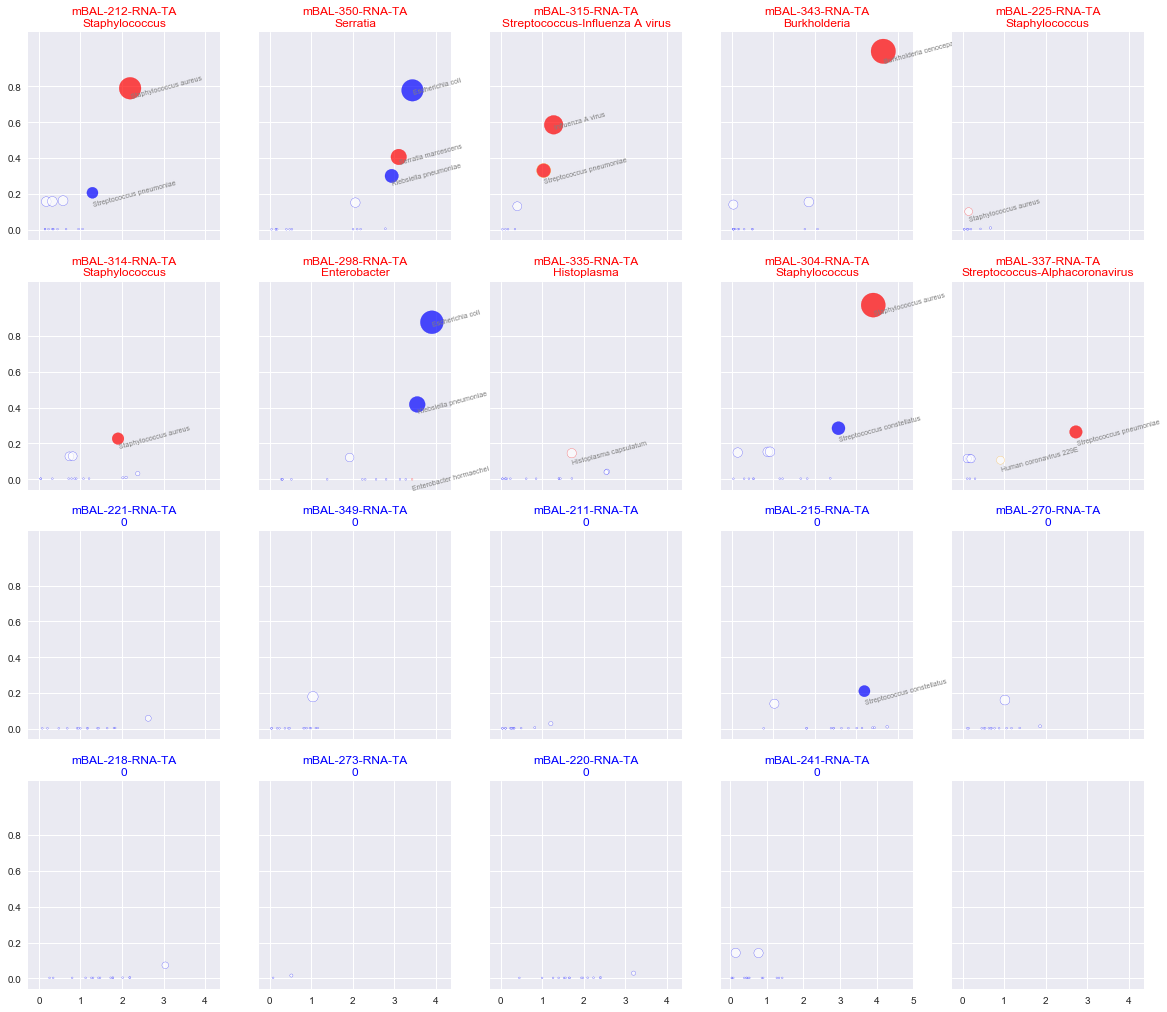

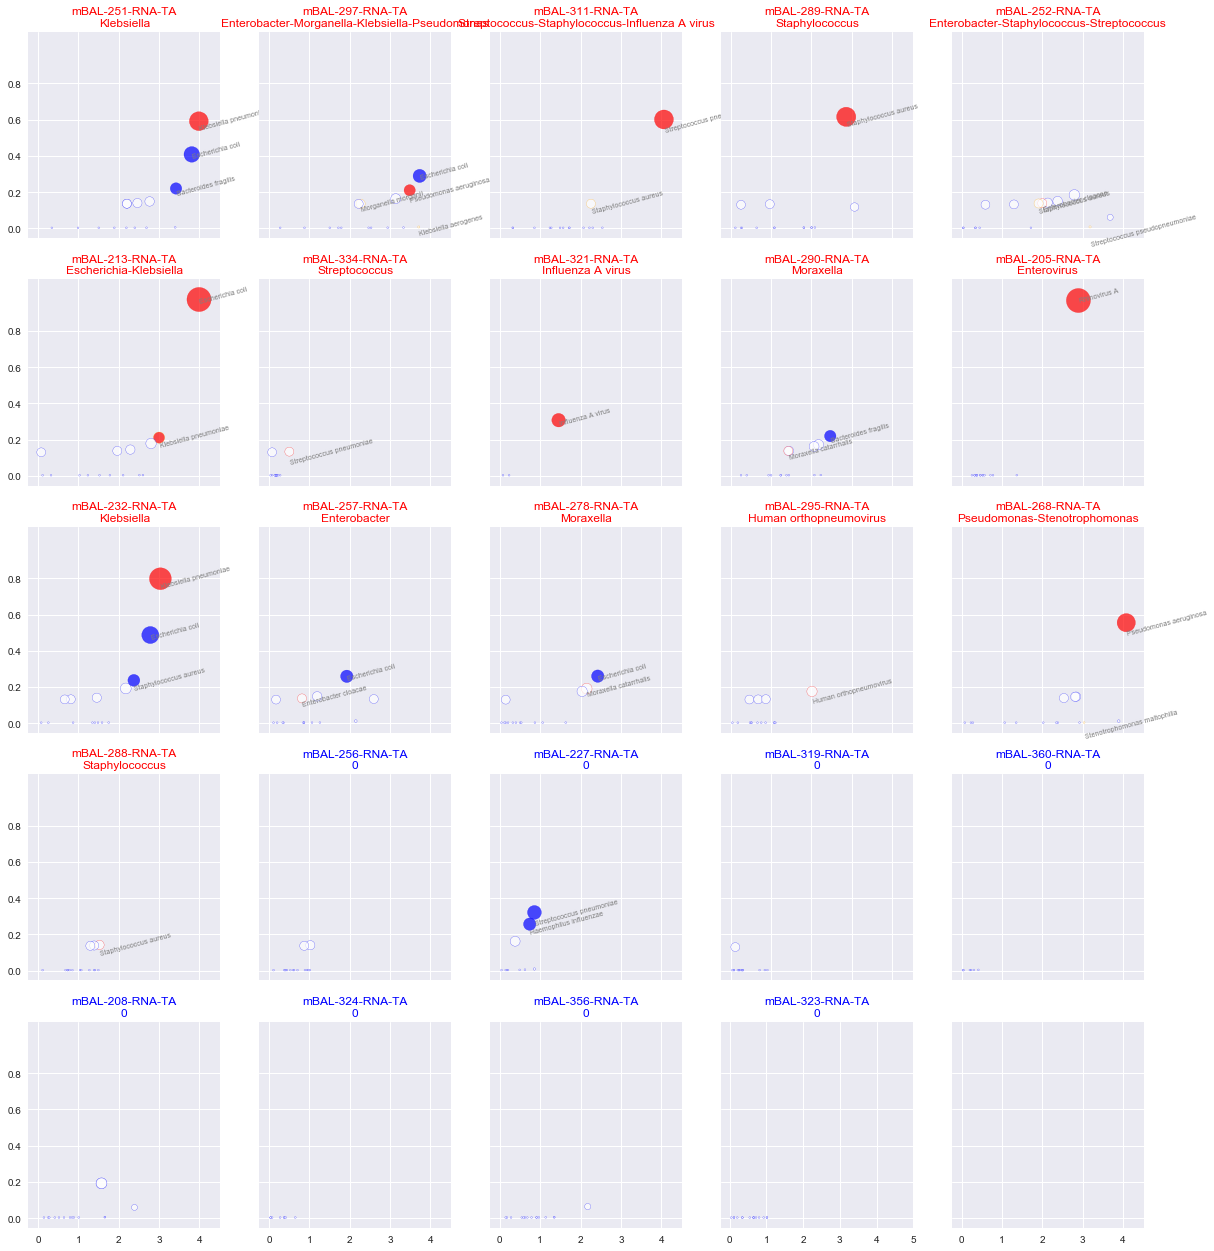

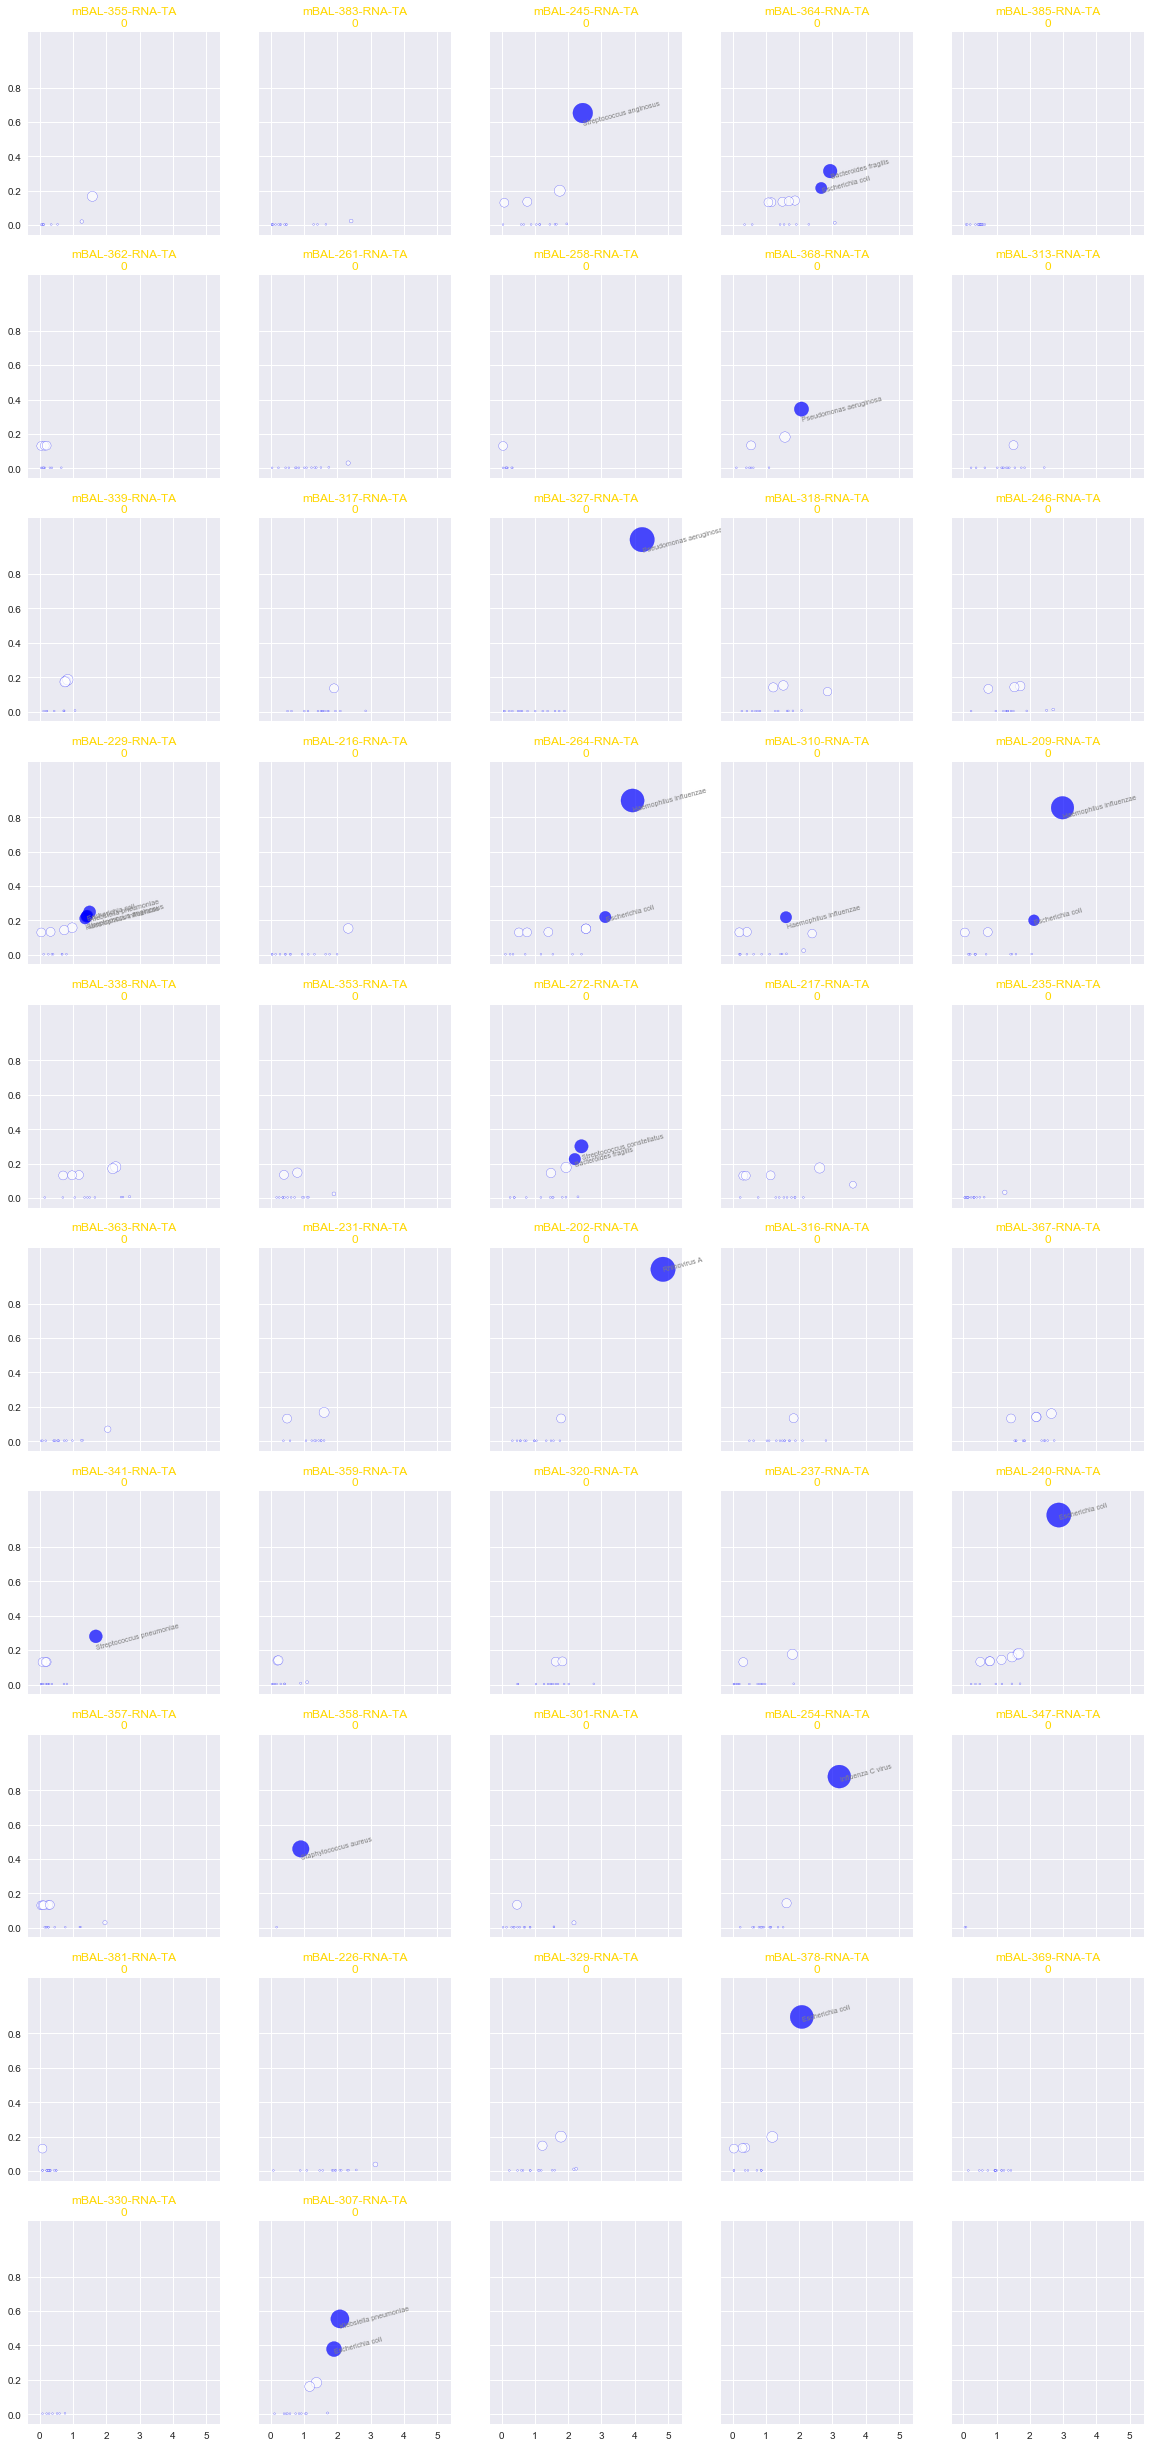

In [43]:
print("TRAINING RESULTS")
IDSeq_plotting_functions_v2.per_sample_result_plots_sorted(X_train, './output/' + output_directory + '/Investigate_Train.pdf', 4, PROBABILITY_THRESHOLD, parameters['graph_axis'],parameters['label'],parameters['positive_class'], parameters['negative_class'], parameters['unknown_class'])

print("\nTEST RESULTS")
IDSeq_plotting_functions_v2.per_sample_result_plots_sorted(X_test, './output/' + output_directory + '/Investigate_Test.pdf', 5, PROBABILITY_THRESHOLD, parameters['graph_axis'],parameters['label'],parameters['positive_class'], parameters['negative_class'], parameters['unknown_class'])

print("\nGROUP 2 RESULTS")
IDSeq_plotting_functions_v2.per_sample_result_plots_sorted(X_unk, './output/' + output_directory + '/Investigate_G2.pdf', 10, PROBABILITY_THRESHOLD, parameters['graph_axis'],parameters['label'],parameters['positive_class'], parameters['negative_class'], parameters['unknown_class'])

#print("\nGROUP 3 RESULTS")
#IDSeq_plotting_functions_v2.per_sample_result_plots(X_g3, './output/' + output_directory + '/Investigate_G3.pdf', 3, PROBABILITY_THRESHOLD, paramters['graph_axis'])

TEST AUC for predicting sampleIDs G1 v. G4 = 0.890625


No handles with labels found to put in legend.


Original ROC area: 0.891, [0.741 - 1.0]

At probability threshold = 0.2
TP, FP, TN, FN
(12, 1, 7, 4)


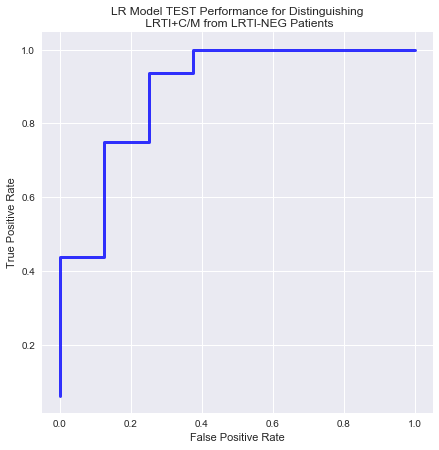

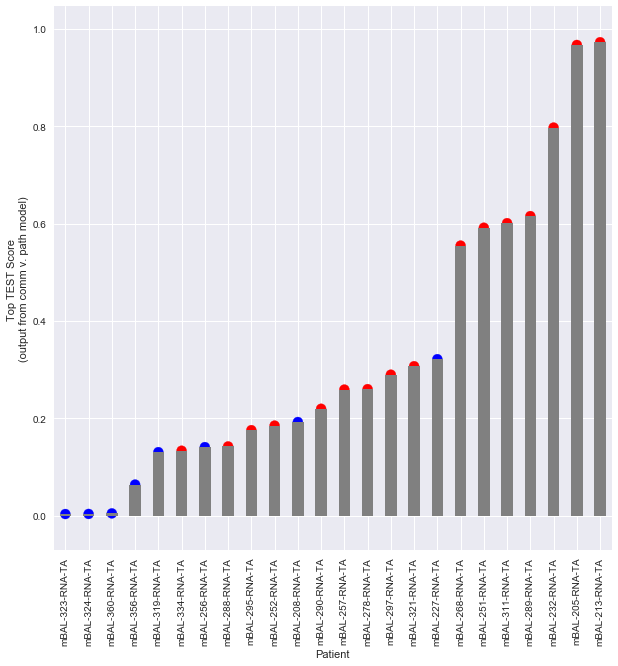

In [44]:
# Get the per-sampleID max score for microbe sampleID model
test_max_scores = []
test_max_truth = []
for i in set(X_test['sampleID']):
    test_max_scores.append(
        max(X_test[X_test['sampleID']==i]['score']))
    test_max_truth.append(
        list(set(X_test[X_test['sampleID']==i]['LRTIstatus']))[0])
    
# calculate performance metrics for the test set LRTI v. no-LRTI  
fpr, tpr, thresholds = metrics.roc_curve(test_max_truth, test_max_scores, pos_label= parameters['positive_class'])  
print("TEST AUC for predicting sampleIDs G1 v. G4 = " + 
      str(metrics.roc_auc_score([int(i== parameters['positive_class']) for i in test_max_truth], test_max_scores)))
IDseq_pathogen_functions2.get_CI([int(i== parameters['positive_class']) for i in test_max_truth], test_max_scores, 1000)

print("\nAt probability threshold = " + str(PROBABILITY_THRESHOLD))
print("TP, FP, TN, FN")
print(IDseq_pathogen_functions2.perf_measure([i > PROBABILITY_THRESHOLD for i in test_max_scores], 
                                      [int(i== parameters['positive_class']) for i in test_max_truth]))


plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='b',
         lw=3, alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR Model TEST Performance for Distinguishing\n LRTI+C/M from LRTI-NEG Patients')
plt.legend(loc="lower right")
plt.savefig('./output/' + output_directory + '/FigureS2B.pdf')
plt.show()

# Create plot of max predicted probability score by sampleID - for visualization 
# and double-checking feasability of AUC
plt.ylabel("Top TEST Score \n(output from comm v. path model)")
plt.xlabel("Patient")
c=['b','r']
df = pd.DataFrame.from_dict(dict(zip(list(set(X_test['sampleID'])),test_max_scores)),
                            orient='index')
df.index = [i.split('.')[0] for i in df.index]
df['color'] = [int(i ==  parameters['positive_class']) for i in test_max_truth]
df.sort_values(by=0,inplace=True)
plt.scatter([i for i in range(len(df[0]))],df[0],color=[c[i] for i in df['color']],s=100)
df[0].plot(kind='bar',color='grey', figsize=(10,10))
plt.savefig('./output/' + output_directory + '/FigureX2.pdf')
plt.show()

#print(df)